In [1]:
# Author: Chad Lohrli + COGS181 Starter Code
# Date: December 24,2017
# Discription: Predicting Time Series Points w/ Recurrent Neural Network
# Framework: Tensorflow

In [2]:
#Libraries
from tensorflow.python.framework import ops
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
%matplotlib inline

In [3]:
def generate_sample(f = 1.0, batch_size = 1,
                    predict = 1, samples = 100):
    """
    Generates data samples.
    :param f: The frequency to use for all time series.
    :param batch_size: The number of time series to generate.
    :param predict: The number of future samples to generate.
    :param samples: The number of past (and current) samples to generate.
    :return: Tuple that contains the past times and values as well as the future times and values. In all outputs,
             each row represents one time series of the batch.
    """
    const = 100.0

    # Empty batch vectors.
    T = np.empty((batch_size, samples))
    Y = np.empty((batch_size, samples))
    FT = np.empty((batch_size, predict))
    FY = np.empty((batch_size, predict))

    for i in range(batch_size):
        # We define the range of t here.
        t = np.arange(0, samples + predict) / const #size=101
        
        # Here we want to sample some points for sine function.
        t0 = random.choice(t)             # t0 is a random single value.
        y = np.sin(2*np.pi*f*(t+t0))              # y = F(t).
        
        T[i, :] = t[0:samples]        # t_1 ... t_{n_samples}
        Y[i, :] = y[0:samples]        # y_1 ... y_{n_samples}

        FT[i, :] = t[samples:samples+predict]      # t_{n_samples+1} ... t_{n_samples+n_predict}
        FY[i, :] = y[samples:samples+predict]     # y_{n_samples+1} ... y_{n_samples+n_predict}
        
    return T, Y, FT, FY

In [4]:
def RNN(x, weights, biases, n_input, n_steps, n_hidden):
    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input).
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input).
    x = tf.split(x, n_steps, axis=0)

    # Define a RNN cell with TensorFlow.
    rnn_cell = rnn.BasicRNNCell(n_hidden)
    
    # Get RNN cell output.
    # Hint: Use rnn.static_rnn()
    outputs, states = rnn.static_rnn(rnn_cell,x, dtype=tf.float32)
    
    # Linear layer and tanh activation, using RNN inner loop last output.
    # Hint: Use tf.tanh, tf.nn.bias_add(), tf.matmul(), weights, biases.
    final_output = tf.tanh(tf.matmul(outputs[-1],weights) + biases)
    
    return final_output

In [5]:
# Parameters
learning_rate = 0.001
training_iters = 50000
batch_size = 50
display_step = 100

# Network Parameters
n_input = 1     # Input is sin(x).
n_steps = 100   # Timesteps.
n_hidden = 100  # Hidden layer num of features.
n_outputs = 1   # Output is sin(x+1).

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_outputs])

# Define weights
weights = tf.Variable(tf.random_normal([n_hidden, n_outputs]))
biases = tf.Variable(tf.random_normal([n_outputs]))

pred = RNN(x, weights, biases, n_input, n_steps, n_hidden)

# Define loss (Euclidean distance) and optimizer.
individual_losses = tf.reduce_sum(tf.squared_difference(pred, y), reduction_indices=1)
loss = tf.reduce_mean(individual_losses)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# Initializing the variables.
init = tf.global_variables_initializer()

In [6]:
# Launch the graph.
sess = tf.Session()
sess.run(init)

step = 1
# Keep training until reach max iterations.
while step * batch_size < training_iters:
    _, batch_x, __, batch_y = generate_sample(f=1.0, batch_size=batch_size, samples=n_steps,
                                              predict=n_outputs)

    batch_x = batch_x.reshape((batch_size, n_steps, n_input))
    batch_y = batch_y.reshape((batch_size, n_outputs))

    # Run optimization op (backprop).
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    if step % display_step == 0:
        # Calculate batch loss.
        loss_value = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        print("Iter " + str(step * batch_size) + ", Minibatch Loss= " +
              "{:.6f}".format(loss_value))
    step += 1
print("Optimization Finished!")

Iter 5000, Minibatch Loss= 0.004468
Iter 10000, Minibatch Loss= 0.000144
Iter 15000, Minibatch Loss= 0.000117
Iter 20000, Minibatch Loss= 0.000091
Iter 25000, Minibatch Loss= 0.000187
Iter 30000, Minibatch Loss= 0.000097
Iter 35000, Minibatch Loss= 0.000175
Iter 40000, Minibatch Loss= 0.000334
Iter 45000, Minibatch Loss= 0.000082
Optimization Finished!


In [7]:
# Test the prediction.
t, start_y, next_t, expected_y = generate_sample(f=1, samples=n_steps, predict=50)

pred_y = []
y = start_y

for i in range(50):
    test_input = y.reshape((1, n_steps, n_input))
    prediction = sess.run(pred, feed_dict={x: test_input})
    prediction = prediction.squeeze()
    pred_y.append(prediction)
    y = np.append(y.squeeze()[1:], prediction)

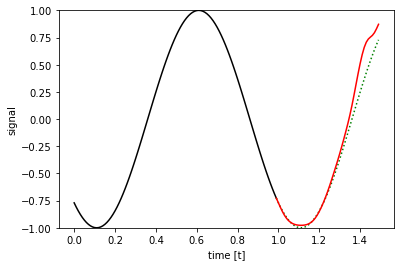

In [8]:
# Remove the batch size dimensions.
t = t.squeeze()
start_y = start_y.squeeze()
next_t = next_t.squeeze()

plt.plot(t, start_y, color='black')
plt.plot(np.append(t[-1], next_t), np.append(start_y[-1], expected_y), color='green', linestyle=':')
plt.plot(np.append(t[-1], next_t), np.append(start_y[-1], pred_y), color='red')
plt.ylim([-1, 1])
plt.xlabel('time [t]')
plt.ylabel('signal')

plt.show()